In [60]:
import os
from tqdm import tqdm

datasets_dir = 'data'

train_img_dataset_dir = datasets_dir + '/train_imgs'
val_img_dataset_dir = datasets_dir + '/val_imgs'
test_img_dataset_dir = datasets_dir + '/test_imgs'

train_voxel_dataset_dir = datasets_dir + '/train_voxels'
val_voxel_dataset_dir = datasets_dir + '/val_voxels'
test_voxel_dataset_dir = datasets_dir + '/test_voxels'

print(datasets_dir)

data


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
import random
from collections import defaultdict
from scipy import ndimage

# For reproducibility
torch.manual_seed(1234)
  
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


In [62]:
from util import image_grid, render_voxels

# Set up dataloaders

In [63]:
print(len(list(os.listdir(train_img_dataset_dir))))
print(len(list(os.listdir(train_voxel_dataset_dir))))

print(len(list(os.listdir(val_img_dataset_dir))))
print(len(list(os.listdir(val_voxel_dataset_dir))))

print(len(list(os.listdir(test_img_dataset_dir))))
print(len(list(os.listdir(test_voxel_dataset_dir))))

33673
33674
4917
4918
10010
10011


In [71]:
import scipy.io
from PIL import Image
import random
from ShapeNetDataset import MultiShapeNetDataset

num_images_per_model = 12

train_dataloader = DataLoader(MultiShapeNetDataset('train', 12, downsample_size = 32), batch_size=4, shuffle=True, num_workers=2)
test_dataloader = DataLoader(MultiShapeNetDataset('test', 12, downsample_size = 32), batch_size=4, shuffle=True, num_workers=2)
val_dataloader = DataLoader(MultiShapeNetDataset('val', 12, downsample_size = 32), batch_size=4, shuffle=True, num_workers=2)

print(len(train_dataloader), len(test_dataloader), len(val_dataloader))

33673 33674 210 000003 to 000326
10010 10011 60 000001 to 000301
4917 4918 30 000009 to 000322
53 15 8


In [72]:
imagebatch, voxelbatch, _ = next(iter(val_dataloader))
print(f"Image shape: {imagebatch.shape}")
print(f"Voxel shape: {voxelbatch.shape}")

Image shape: torch.Size([4, 12, 3, 256, 256])
Voxel shape: torch.Size([4, 1, 32, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


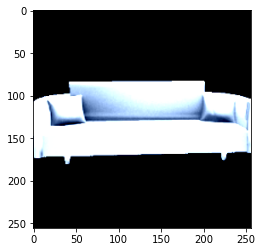

/state/partition1/slurm_tmp/22522793.0.0/ipykernel_65250/3485003931.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel, dtype = torch.float)


<Figure size 432x288 with 0 Axes>

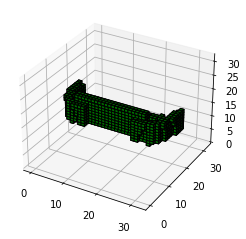

In [73]:
img = imagebatch[1][0].to(device)
voxel = voxelbatch[1].to(device)
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.show()

render_voxels(voxel.cpu())
plt.show()

# Set up models

torch.Size([8, 1, 32, 32, 32])


/state/partition1/slurm_tmp/22522793.0.0/ipykernel_65250/3485003931.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel, dtype = torch.float)


<Figure size 432x288 with 0 Axes>

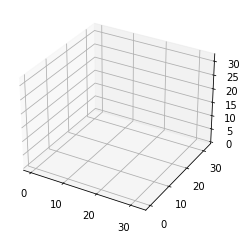

In [54]:
from models import ImageEncoder, MultiEncoderDecoder

embedding_dims = 64
encoder_decoder = MultiEncoderDecoder(embedding_dims).to(device) 

out_voxel = encoder_decoder(imagebatch.to(device))
# out_voxel = encoder_decoder(voxelbatch.to(device))

print(out_voxel.shape)

image = render_voxels(out_voxel[0].cpu().detach() > 0.5, downsample_size = 32)

# Set up IoU and Loss

In [56]:
from eval import evaluate_voxel_prediction

print(voxelbatch.shape)
print(evaluate_voxel_prediction(voxelbatch, voxelbatch))
print(evaluate_voxel_prediction(voxelbatch, torch.rand(voxelbatch.shape) >= 0.5))

print(evaluate_voxel_prediction(voxelbatch[0], voxelbatch[1]))
print(evaluate_voxel_prediction(voxelbatch-0.9, voxelbatch-0.9))
print(evaluate_voxel_prediction((voxelbatch-0.9) > 0.8, (voxelbatch-0.9) > 0.8))


torch.Size([8, 1, 32, 32, 32])
tensor(1.)
tensor(0.0663)
tensor(0.)
tensor(1.)
tensor(0.)


In [57]:
loss = nn.BCELoss()
print(loss(voxelbatch.float(), voxelbatch.float()))

tensor(0.0037)


# Train

In [ ]:
from train_func import train_model

model_1 = MultiEncoderDecoder(embedding_dims).to(device) 
# model_1.load_state_dict('models/')

dataloaders = {'test': test_dataloader, 'train': train_dataloader, 'val': val_dataloader}
criterion = nn.BCELoss()

learning_rate = 1e-4
optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate)

save_dir = 'models/'
save_all_epochs = False
num_epochs = 4

trained_model_1, validation_history_1, train_history_1 = train_model(model=model_1, 
                                                                     dataloaders=dataloaders, 
                                                                     criterion=criterion, 
                                                                     optimizer=optimizer_1,
                                                                     save_dir=save_dir, 
                                                                     save_all_epochs=save_all_epochs, 
                                                                     num_epochs=num_epochs)

# Evaluate

In [66]:
# voxel_encoder_decoder = EncoderDecoder(embedding_dims).to(device) 
# voxel_encoder_decoder.load_state_dict(torch.load('models/voxel_encoder_decoder_weights_best_val_acc_64.pt', 
#                                                 map_location=torch.device(device)))
# voxel_encoder_decoder.eval()
# voxel_encoder = voxel_encoder_decoder.encoder
# voxel_decoder = voxel_encoder_decoder.decoder


# img_encoder = ImageEncoder(embedding_dims).to(device) 
# img_encoder.load_state_dict(torch.load('models/image_encoder_weights_best_val_acc_64.pt',
#                                       map_location=torch.device(device)))
# img_encoder.eval()
# print('Loaded models')

Loaded models


In [27]:
# imagebatch, voxelbatch, _ = next(iter(test_dataloader))
# print(f"Image shape: {imagebatch.shape}")
# print(f"Voxel shape: {voxelbatch.shape}")

# img = imagebatch[:1]
# vox = voxelbatch[:1]

# plt.imshow(img[0][0].permute(1, 2, 0).cpu().numpy())
# plt.show()

# voxel_emb = voxel_encoder(vox)
# img_emb = img_encoder(img)
# print(voxel_emb)
# print(img_emb)

# voxel_pred_img = voxel_decoder(img_emb)
# print(voxel_pred_img.shape)

# voxel_pred_vox = voxel_decoder(voxel_emb)
# print(voxel_pred_vox.shape)

In [28]:
# print('Actual:')
# render_voxels(vox.cpu() >= 0.5)
# plt.show()

# print('Image to 3D: ', evaluate_voxel_prediction(voxel_pred_img[0] >= 0.5, vox[0]))
# render_voxels(voxel_pred_img.cpu() >= 0.5)
# plt.show()

# print('Voxel to 3D: ', evaluate_voxel_prediction(voxel_pred_vox[0] >= 0.5, vox[0]))
# render_voxels(voxel_pred_vox.cpu() >= 0.5)
# plt.show()

## Average IoU

In [40]:
from eval import calc_average_iou

eval_model = model_1
print('Average Test IoU:', calc_average_iou(eval_model, test_dataloader))

  0%|          | 0/15 [00:00<?, ?it/s]

0.0307912640273571
0.01919947937130928
0.12277167290449142
0.042490117251873016
0.15746872127056122
0.07939557731151581
0.07811279594898224
0.05263157933950424
0.0042372881434857845
0.08640442788600922
0.01596558280289173
0.11334133893251419
0.07700386643409729
0.06804853677749634
0.1602429300546646
0.07387367856378356


## Predict Voxels

In [46]:
imagebatch, voxelbatch, _ = next(iter(test_dataloader))
print(f"Image shape: {imagebatch.shape}")
print(f"Voxel shape: {voxelbatch.shape}")

Image shape: torch.Size([4, 12, 3, 256, 256])
Voxel shape: torch.Size([4, 1, 32, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


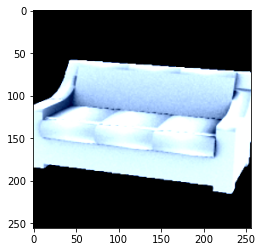

/state/partition1/slurm_tmp/22522793.0.0/ipykernel_47777/3485003931.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel, dtype = torch.float)


torch.Size([1, 32, 32, 32])


<Figure size 432x288 with 0 Axes>

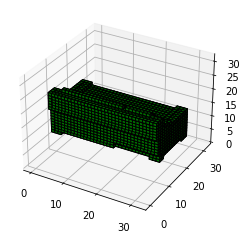

In [47]:
img = imagebatch[0][1].to(device)
voxel = voxelbatch[0].to(device)
plt.imshow(img.permute(1, 2, 0).cpu().numpy())
plt.show()

print(voxel.shape)
render_voxels(voxel.cpu())
plt.show()

In [ ]:
threshold = 0.5

# print(imagebatch.to(device).get_device())

pred = eval_model(imagebatch.to(device))
print(torch.max(pred), torch.min(pred))

pred_voxel = pred.cpu() >= threshold
print(evaluate_voxel_prediction(pred_voxel[0], voxel))

print(pred_voxel.shape)

render_voxels(pred_voxel[0].cpu())
plt.show()

## Interpolation

In [108]:
encoder = eval_model.encoder
decoder = eval_model.decoder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


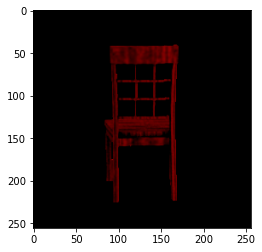

/state/partition1/slurm_tmp/22415461.0.0/ipykernel_16783/3485003931.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel, dtype = torch.float)


<Figure size 432x288 with 0 Axes>

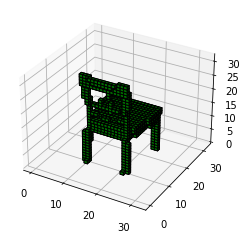

In [191]:
img2 = imagebatch[25].to(device)
voxel2 = voxelbatch[25].to(device)
plt.imshow(img2.permute(1, 2, 0).cpu().numpy())
plt.show()

render_voxels(voxel2.cpu())
plt.show()

tensor(0.7926, device='cuda:0', grad_fn=<MaxBackward1>) tensor(8.2388e-12, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.1684, device='cuda:0')
torch.Size([1, 1, 32, 32, 32])


/state/partition1/slurm_tmp/22415461.0.0/ipykernel_16783/3485003931.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voxel = torch.tensor(voxel, dtype = torch.float)


<Figure size 432x288 with 0 Axes>

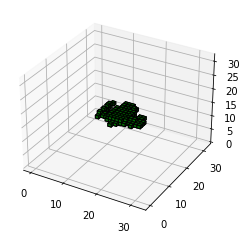

In [192]:
pred2 = eval_model(voxel2.detach().unsqueeze(0))
print(torch.max(pred2), torch.min(pred2))

pred_voxel2 = pred2 >= 0.5

print(evaluate_voxel_prediction(pred_voxel2[0], voxel2))
print(pred_voxel2.shape)

render_voxels(pred_voxel2[0].cpu())
plt.show()

torch.Size([64]) torch.Size([64])
5


<Figure size 432x288 with 0 Axes>

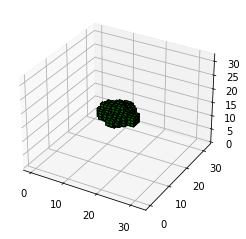

<Figure size 432x288 with 0 Axes>

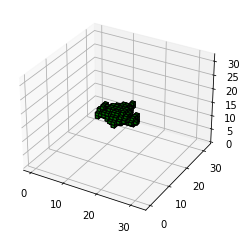

<Figure size 432x288 with 0 Axes>

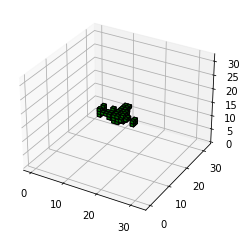

<Figure size 432x288 with 0 Axes>

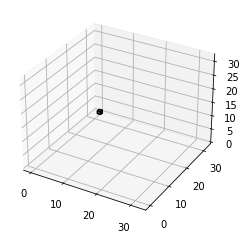

<Figure size 432x288 with 0 Axes>

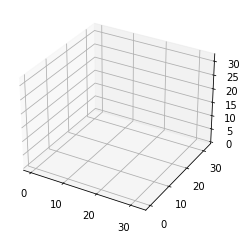

In [118]:
from eval import interpolate_embs

with torch.no_grad():
    emb1 = encoder(voxel.unsqueeze(0))[0]
    emb2 = encoder(voxel2.unsqueeze(0))[0]
    print(emb1.shape, emb2.shape)

    embs = interpolate_embs(emb1, emb2, n_steps = 5)
    print(len(embs))
    for emb in embs:
        interp_voxel = decoder(emb.unsqueeze(0)) >= threshold
        render_voxels(interp_voxel[0].cpu())
        plt.show()